# 論文のクラスタリングを実装する

## 画像データの取得

画像データを入手してくるのは手間なので，Pythonのscikit-learnで用意されている適当な画像データを持ってきます：

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import permutations

sklearnはscikit-learnの略です．そのデータセットから，ひとまず適当に fetch_olivetti_faces というデータセットを持ってきています．これは，同一人物の様々な状態の顔画像 (40人×10枚)からなるデータセットで，分類(クラスタリング)問題を考えるために準備されたデータセットです．次のようにして読み込みます：

In [2]:
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images
labels = data.target

これで，images に画像のデータ，labels に正解ラベル ( 人に番号が振られていて，同じ番号の人が同一人物 ) が入ります．images がどういうデータになっているかちょっと見てみます．

In [3]:
images.shape

(400, 64, 64)

400はデータ数です．上で書いた通り，これは40人×10枚の画像からなるので，合計400枚の画像データからなります．後ろにある2つの64は，画像データが64×64の行列で表されていることを意味しています．試しに，1つ目の画像にアクセスしてみます．images[0] を実行すると次のようになります：

In [4]:
images[0]

array([[0.1983471 , 0.23553719, 0.35123968, ..., 0.5041322 , 0.5289256 ,
        0.5289256 ],
       [0.19421488, 0.24380165, 0.36363637, ..., 0.5041322 , 0.5165289 ,
        0.5289256 ],
       [0.1983471 , 0.2520661 , 0.35950413, ..., 0.5123967 , 0.5123967 ,
        0.5247934 ],
       ...,
       [0.35950413, 0.57024795, 0.55785125, ..., 0.11570248, 0.0785124 ,
        0.09917355],
       [0.55785125, 0.607438  , 0.5785124 , ..., 0.07438017, 0.07438017,
        0.12809917],
       [0.62396693, 0.59090906, 0.6280992 , ..., 0.06198347, 0.12809917,
        0.09090909]], dtype=float32)

行列っぽくはなってそうなので，実際にサイズを確かめてみます．images[0].shape を実行すると

In [5]:
images[0].shape

(64, 64)

と出力されるので，確かに $64 \times 64$ の画像になっています．

試しに，頭から10枚の画像を出力してみましょう．次のコードを実行します：

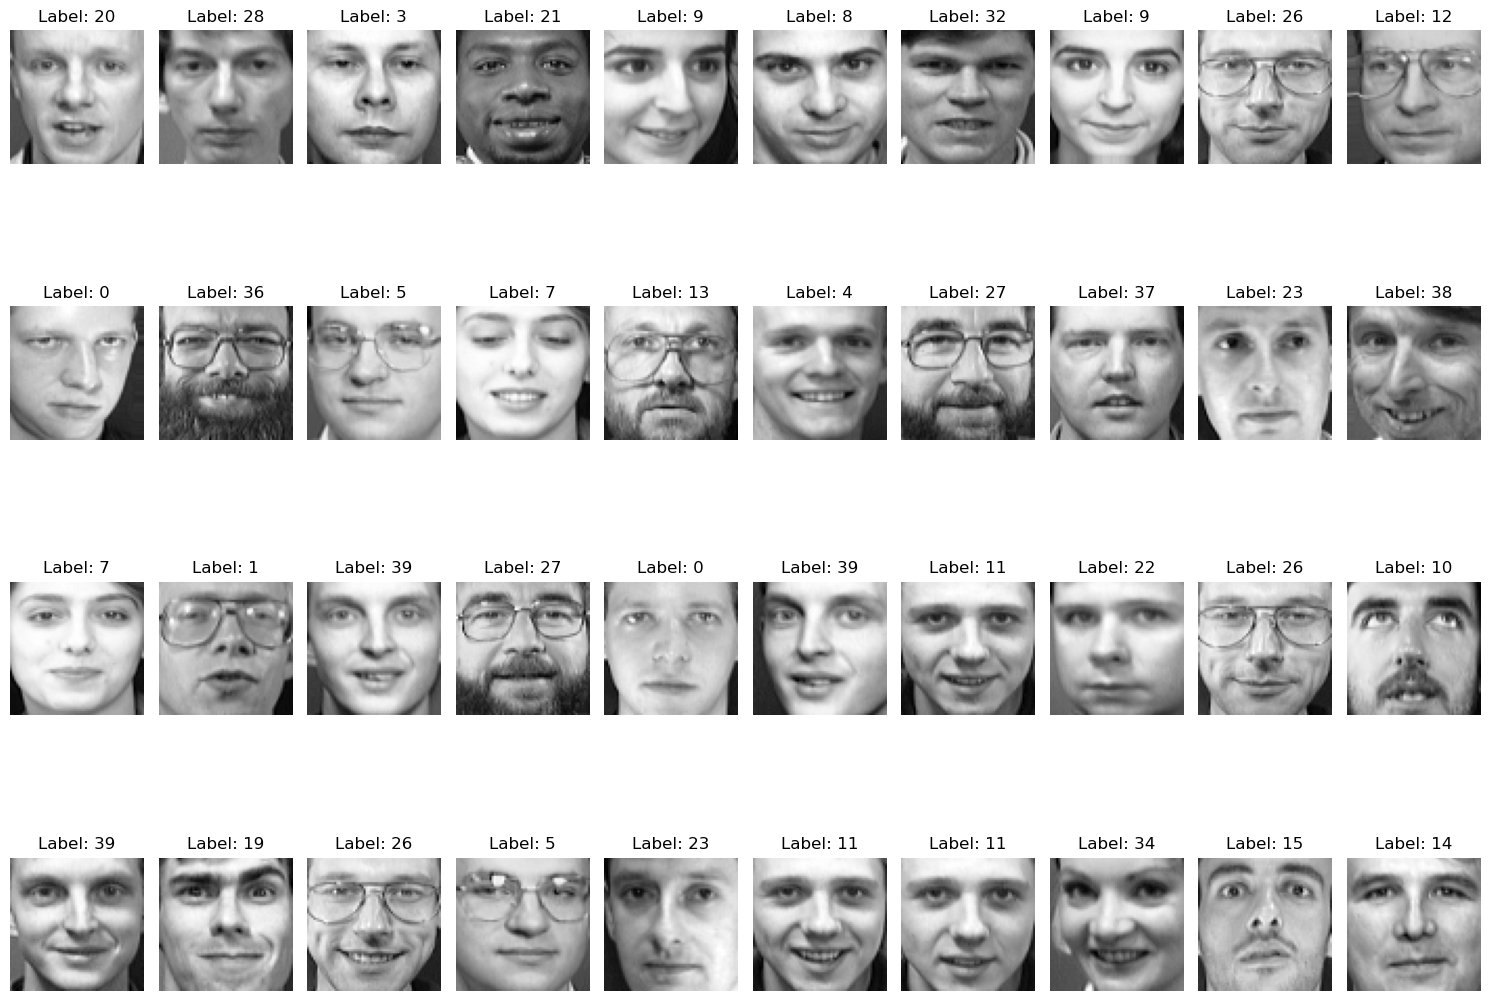

In [6]:
def show_images_with_labels(images, labels, num_images_per_row=10, total_images=50):
    rows = total_images // num_images_per_row
    fig, axes = plt.subplots(rows, num_images_per_row, figsize=(15, 3 * rows))
    for i in range(total_images):
        row = i // num_images_per_row
        col = i % num_images_per_row
        ax = axes[row, col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 画像とラベルを表示
show_images_with_labels(images, labels, num_images_per_row=10, total_images=40)

このように，データセットの中には，確かに人の画像と，正解ラベルが入っていることが確認できました．

## 類似度の計算

論文の方針としては，類似度で重み付けをしたグラフを作成するので，画像同士の類似度を測る関数が必要になります．論文では，Gaussカーネルという指標を使って類似度を計算していました．Gaussカーネルの定義は以下の通りです(論文p.8，左側1段落目)：

\begin{equation*}
  w(v_{i}, v_{j}) = \exp \left( - \frac{d(v_{i}, v_{j})^{2}}{2 \sigma^{2}} \right)
\end{equation*}
(ただし，$d(v_{i}, v_{j})$ は標本 $i$ と $j$ のペア間距離，$\sigma$ はカーネル帯域幅)

これを実装してみます：

In [7]:
def gaussian_kernel(vi, vj, kernel_bandwidth=1.0):
    distance = np.linalg.norm(vi - vj)
    return np.exp(-distance**2 / (2 * kernel_bandwidth**2))

カーネル帯域幅の値の設定については恐らくデータの種類ごとで違う値を設定するものと思われるので，一旦適当に値を定めます．
論文のp.10左側の式(23)の後に，カーネル帯域幅を $\sigma = 5$ としている箇所があるので，取り敢えずその設定で二つの画像の類似度を見てみます．

まずは違う人物(ラベルが違う)の類似度を見てみます．

In [8]:
image1 = images[0]
image2 = images[13]
print(f"Label of image1: {labels[0]}")
print(f"Label of image2: {labels[13]}")
print(f"Gauss kernel: {gaussian_kernel(image1, image2, kernel_bandwidth=5)}")

Label of image1: 20
Label of image2: 7
Gauss kernel: 0.005820748135672242


次に，同じ人物(ラベルが同じ)の類似度を見てみます．

In [9]:
image1 = images[13]
image2 = images[20]
print(f"Label of image1: {labels[13]}")
print(f"Label of image2: {labels[20]}")
print(f"Gauss kernel: {gaussian_kernel(image1, image2, kernel_bandwidth=5)}")

Label of image1: 7
Label of image2: 7
Gauss kernel: 0.4539309720905074


上の二つを比較してみると，同一人物の方がガウスカーネルの値が大きくなっている，つまり，類似度が大きくなっているので良さそうですね．

## 類似度グラフの作成

ガウスカーネルを類似度として設定して，類似度グラフを作成します．
グラフを扱うためのnetworkxというライブラリと，要素ごとの距離を計算するためのpairwise_distances関数をインポートします．

In [10]:
import networkx as nx
from sklearn.metrics import pairwise_distances

$k$-近傍グラフを構成する関数を作ります．データと $k$ の値を指定して作る形にします．

In [11]:
def construct_graph(data, k=2):
    similarities = pairwise_distances(data, metric=lambda vi, vj: gaussian_kernel(vi, vj, kernel_bandwidth=5))
    graph = nx.Graph()
    for i in range(data.shape[0]):
        neighbors = np.argsort(similarities[i])[1:k+1]
        for j in neighbors:
            graph.add_edge(i, j, weight=similarities[i, j])
    return graph

全データだと400枚と多いので，4人くらいから5枚ずつ写真を取って来てグラフを実際に作ってみます．

In [43]:
K = 4
Number_of_people = 5
face_list = [1,7,12,36]
# small_images = np.array([images[np.where(labels==i)[0][:5]] for i in [7, 10, 1, 17]]).reshape(20, 64, 64)
# small_labels = np.array([labels[np.where(labels==i)[0][:5]] for i in [7, 10, 1, 17]]).reshape(20,)
Number_of_picture = Number_of_people*K
small_images = np.array([images[np.where(labels==i)[0][:Number_of_people]] for i in face_list]).reshape(Number_of_picture, 64, 64)
small_labels = np.array([labels[np.where(labels==i)[0][:Number_of_people]] for i in face_list]).reshape(Number_of_picture,)

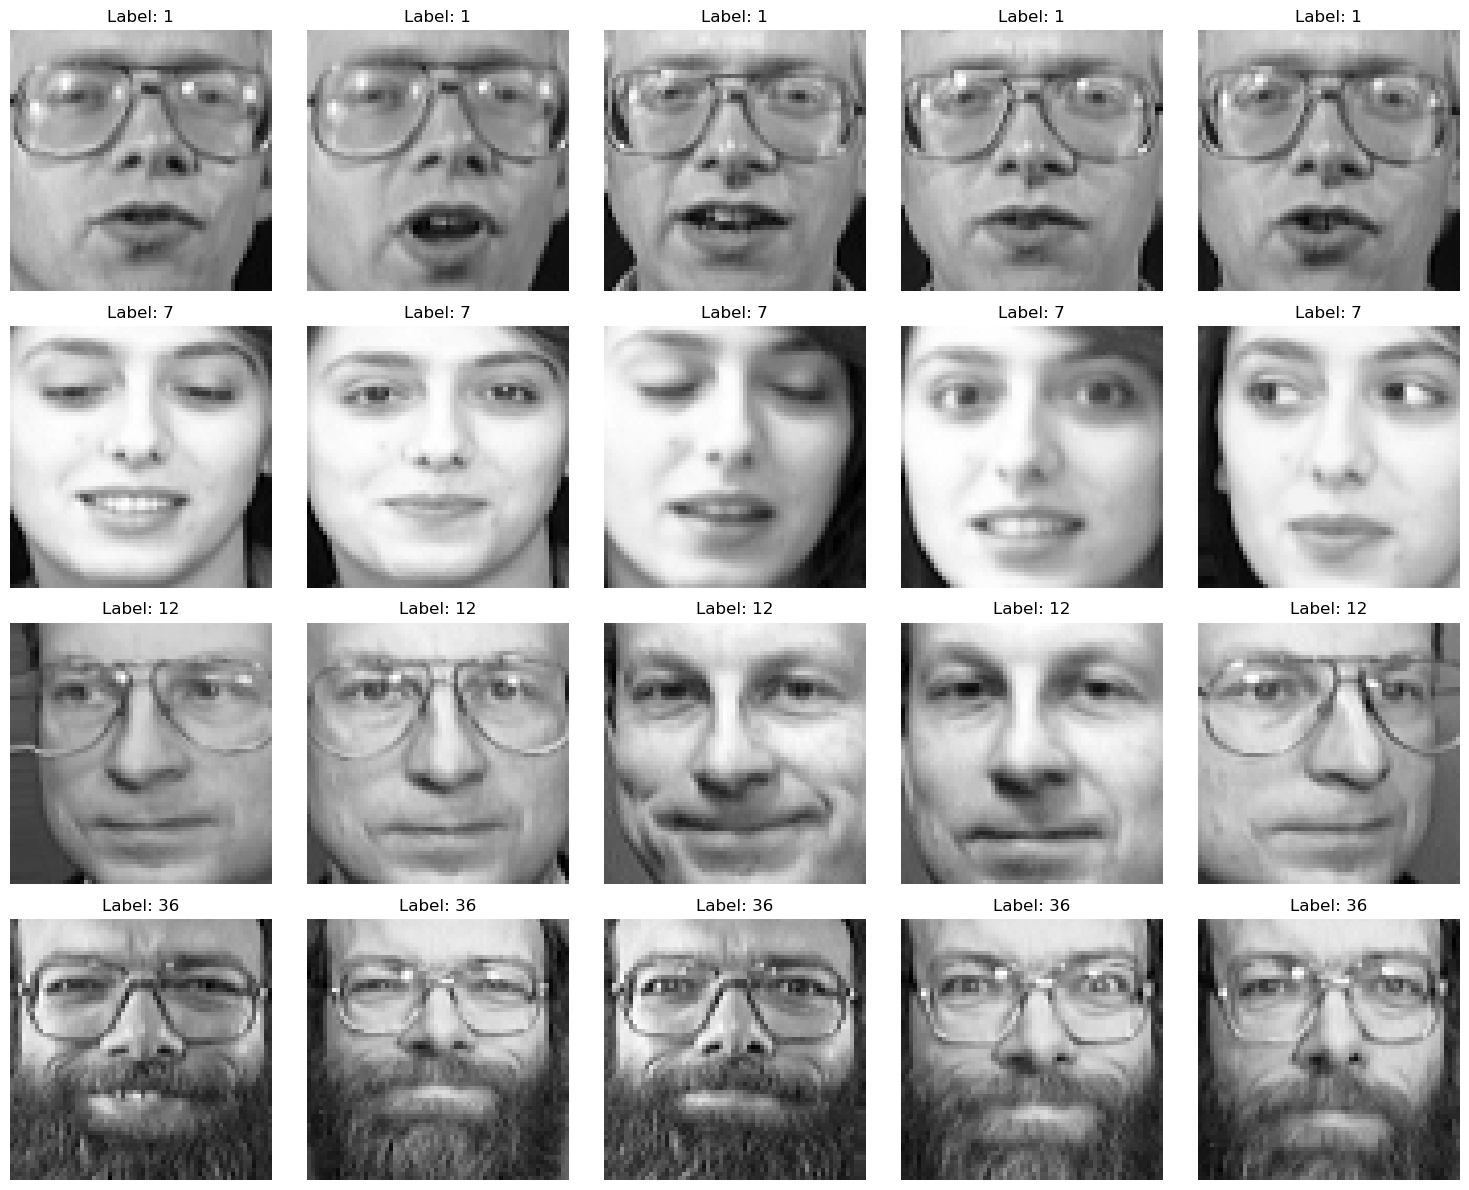

In [44]:
show_images_with_labels(small_images, small_labels, num_images_per_row=Number_of_people, total_images=Number_of_picture)

In [45]:
#similarity_graph = construct_graph(small_images.reshape(20, 64*64), k=5)
similarity_graph = construct_graph(small_images.reshape(Number_of_picture, 64*64), k=Number_of_picture-2)
#show_images_with_labels(small_images[1], small_labels[1],num_images_per_row=1, total_images=1)


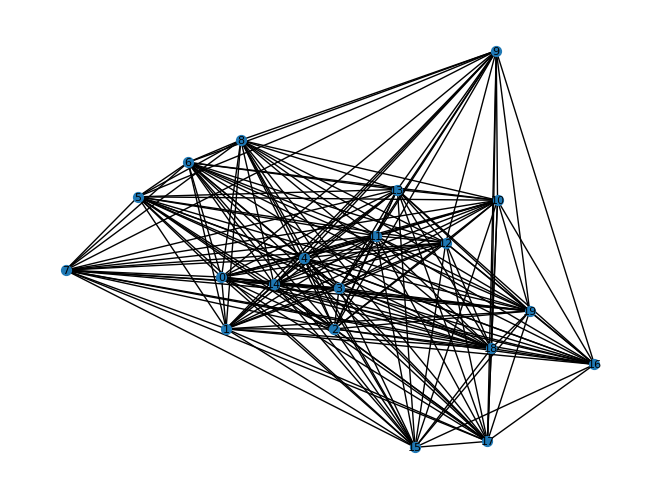

In [46]:
pos = nx.spring_layout(similarity_graph)  # レイアウトの設定
nx.draw(similarity_graph, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

In [47]:
A = similarity_graph.edges[0,2]
print(A['weight'])

0.194066999977439


## エントロピーレートの計算

ランダムウォークの定常分布
\begin{equation} \tag{6}
  {\boldsymbol \mu} = (\mu_{1}, \mu_{2}, \ldots, \mu_{|V|})^{T} = \left( \frac{w_{1}}{w_{T}}, \frac{w_{2}}{w_{T}}, \ldots , \frac{w_{|V|}}{w_{T}} \right)^{T}
\end{equation}
は変わらず，遷移確率に対する集合関数 $p_{i,j} \colon 2^{E} \to \mathbb{R}$

\begin{equation} \tag{11}
  p_{i, j}(A) = \begin{cases}
    \frac{w_{i, j}}{w_{i}} & i \neq j \text{ かつ } e_{i, j} \in A \text{ のとき}, \\
    0 & i \neq j \text{ かつ } e_{i, j} \notin A \text{ のとき}, \\
    1 - \frac{\sum_{j:e_{i,j} \in A} w_{i,j}}{w_{i}} & i = j \text{ のとき}.
  \end{cases}
\end{equation}

グラフ $G = (V, A)$ 上のランダムウォークのエントロピーレート：

\begin{equation} \tag{12}
  \mathcal{H}(A) = - \sum_{i} \mu_{i} \sum_{j} p_{i,j}(A) \log(p_{i,j}(A))
\end{equation}

In [48]:
def entropy_rate(graph):
    stationary_dist = np.array([deg / (graph.size(weight='weight')*2) for node, deg in graph.degree(weight='weight')])
    transition_probs = nx.adjacency_matrix(graph, weight='weight').toarray() / stationary_dist[:, None]
    entropy_rate = -np.sum(stationary_dist[:, None] * transition_probs * np.log2(transition_probs + 1e-12))
    return entropy_rate

In [49]:
print(similarity_graph.size(weight="weight"))
res = sorted(list(similarity_graph.degree(weight="weight")))
for i in range(15):
    print(res[i])

# for nodem, deg in res:
    # print(nodem,deg)

14.152447300042473
(0, 2.1043695853135023)
(1, 1.8314973903037886)
(2, 2.0977851111906625)
(3, 2.5367248212961266)
(4, 2.5188870987096417)
(5, 0.9985798526837536)
(6, 1.0265365703819551)
(7, 0.4711161747616294)
(8, 0.7363251509840856)
(9, 0.23580313706038364)
(10, 1.210169652697711)
(11, 2.1710493257317593)
(12, 1.7531675019890263)
(13, 1.6512080498223776)
(14, 1.5189389300388911)


## 釣り合い項の計算

釣り合い関数を利用し，データ点を大きさが近いクラスタにグループ化することを目指す．$A$ を選択した辺集合とし， $N_{A}$ をそのグラフにおける連結成分数， $Z_{A}$ をクラスターメンバーシップの分布とする．例えば，辺集合 $A$ に対するグラフ分割を $\mathcal{S}_{A} = \{ S_{1}, S_{2}, \ldots , S_{N_{A}} \}$ とする．このとき， $Z_{A}$ の分布は

\begin{equation} \tag{16}
  p_{Z_{A}}(i) = \frac{|S_{i}|}{|V|}, \quad i \in \{ 1, \ldots , N_{A} \}
\end{equation}

に等しく，釣り合い項は

\begin{align}
  \mathcal{B}(A) &\equiv H(Z_{A}) - N_{A} \nonumber \\
    &= -\sum_{i} p_{Z_{A}}(i) \log(p_{Z_{A}}(i)) - N_{A} \tag{17}
\end{align}

で与えられる．

In [50]:
def balancing_term(graph, G):
    connected_components = list(nx.connected_components(graph))
    N_A = len(connected_components)
    
    # クラスターメンバーシップの分布を計算
    cluster_sizes = np.array([len(component) for component in connected_components])
    p_Z_A = cluster_sizes / G.number_of_nodes()


    # エントロピー H(Z_A) の計算
    entropy = -np.sum(p_Z_A * np.log2(p_Z_A + 1e-12))  # 1e-12 を加えることで log(0) を避ける

    # 釣り合い項の計算
    balancing_term_ = entropy - N_A

    return balancing_term_

https://chatgpt.com/c/6703775f-6bd4-8009-8898-bff3c15c59ab

In [51]:
#これは要らない
def entropy_rate(graph, G):
    # グラフが空でないか確認
    if graph.number_of_edges() == 0:
        return 0.0

    # ノードの重み付き次数を取得し、ステーショナリティ分布を計算
    total_weight = G.size(weight='weight')*2  # グラフ全体の重みの合計

    stationary_dist = np.array([deg / total_weight for node, deg in G.degree(weight='weight')])
    print(stationary_dist)
    # for node, deg in  graph.degree(weight='weight'):
    #     print(node,deg)
    # for node, deg in  G.degree(weight='weight'):
    #     print(node,deg)
    BBB = np.zeros((G.number_of_nodes(),G.number_of_nodes()))
    
    # 重み付き隣接行列を取得し、遷移確率行列を作成
    adj_matrix = nx.adjacency_matrix(G, weight='weight').toarray()
    print('重み行列', adj_matrix)
    print()
    # print(adj_matrix)

    # # 行の合計が 0（孤立ノードなど）の場合は、その行をスキップ
    # row_sums = adj_matrix.sum(axis=1, keepdims=True)
    # with np.errstate(divide='ignore', invalid='ignore'):  # ゼロ割りを無視する
    #     transition_probs = np.divide(adj_matrix, row_sums, where=row_sums != 0)

    for node1, deg1 in graph.degree(weight='weight'):
        Check = 0
        for node2, deg2 in graph.degree(weight='weight'):
            if node1 == node2:
                continue
            BBB[node1,node2] += adj_matrix[node1,node2]
            Check += adj_matrix[node1,node2]
        BBB[node1,node1] = 1 - Check
    #print(BBB)

    # 対数計算で 0 を避けるために、非常に小さい値を加える
    log_transition_probs = np.log2(BBB + 1e-12)
    # エントロピー率の計算
    entropy_rate = -np.sum(stationary_dist[:, None] * BBB * log_transition_probs)
    
    return entropy_rate


In [52]:
def edgh_weight_matrix(G):
    edgh_weight_matrix = np.zeros((G.number_of_nodes(),G.number_of_nodes()))
    res = sorted(list(G.degree(weight="weight")))
    
    for u,v in permutations([i for i in range(len(G))], 2):
        try:
            A = G.edges[u,v]
        except KeyError as e:
            A = {"weight": 0}
        edgh_weight_matrix[u,v] = A['weight']/res[u][1]
    return edgh_weight_matrix

In [53]:
for i,j in similarity_graph.edges():
    print(i,j)

0 16
0 17
0 18
0 19
0 15
0 10
0 6
0 5
0 12
0 8
0 13
0 7
0 11
0 14
0 2
0 3
0 4
0 1
0 9
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 17
16 18
16 19
17 1
17 2
17 3
17 4
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 6
17 5
17 19
17 18
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 19
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11
19 12
19 13
19 14
19 15
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 10
15 11
15 12
15 13
15 14
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 14
10 13
10 12
10 11
6 1
6 2
6 3
6 4
6 5
6 9
6 12
6 13
6 7
6 11
6 14
6 8
5 1
5 2
5 3
5 4
5 9
5 12
5 13
5 11
5 14
5 7
5 8
12 1
12 2
12 3
12 4
12 7
12 8
12 9
12 11
12 14
12 13
8 1
8 2
8 3
8 4
8 7
8 9
8 13
8 11
8 14
13 1
13 2
13 3
13 4
13 7
13 9
13 11
13 14
7 1
7 2
7 3
7 4
7 11
7 14
7 9
11 1
11 2
11 3
11 4
11 9
11 14
14 1
14 2
14 3
14 4
14 9
2 1
2 4
2 3
2 9
3 1
3 4
3 9
4 1
4 9
1 9


In [54]:
row_sun = edgh_weight_matrix(similarity_graph)
for i in range(15):
    print(sum(row_sun[i]))

1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999


In [55]:
def entropy_rate(graph, G):
    # グラフが空でないか確認
    if graph.number_of_edges() == 0:
        return 0.0

    # ノードの重み付き次数を取得し、ステーショナリティ分布を計算
    total_weight = G.size(weight='weight')*2  # グラフ全体の重みの合計

    res = sorted(list(G.degree(weight="weight")))
    # stationary_dist = np.array([deg / total_weight for node, deg in G.degree(weight='weight')])
    stationary_dist = np.array([deg / total_weight for node, deg in res])
    BBB = np.zeros((G.number_of_nodes(),G.number_of_nodes()))
    # print("μだよ！！",stationary_dist)
    # 重み付き隣接行列を取得し、遷移確率行列を作成
    adj_matrix = edgh_weight_matrix(G)
    # print("重み分布！！",adj_matrix)
    #部分グラフの重み
    for i,j in graph.edges():
        BBB[i,j] = adj_matrix[i,j]
        BBB[j,i] = adj_matrix[j,i]
    for i in range(G.number_of_nodes()):
        BBB[i,i] = 1-sum(BBB[i])
    # print("連結グラフの重み分布だよ！！",BBB)
    # 対数計算で 0 を避けるために、非常に小さい値を加える
    log_transition_probs = np.log2(BBB + 1e-12)
    # エントロピー率の計算
    entropy_rate = -np.sum(stationary_dist[:, None] * BBB * log_transition_probs)
    # print("entropy_rate",entropy_rate)
    if math.isnan(entropy_rate):
        print("μの個数",len(stationary_dist),"列数",len(BBB[0]))
        print("重み分布！！",adj_matrix)
        print("BBB",BBB)
        print("log",log_transition_probs)
    
    return entropy_rate


In [56]:
print(edgh_weight_matrix(similarity_graph))

[[0.00000000e+00 3.28190162e-01 9.22209679e-02 1.32819256e-01
  1.63521501e-01 1.63149740e-02 1.41855734e-02 2.64035823e-02
  1.96740226e-02 8.53414112e-04 7.99557855e-03 5.20955140e-02
  1.91274274e-02 2.34485915e-02 7.85312219e-02 5.96012976e-03
  2.05427937e-03 5.12673414e-03 5.52216614e-03 5.95490396e-03]
 [3.77086748e-01 0.00000000e+00 8.72223566e-02 1.13422724e-01
  1.51675668e-01 1.51925106e-02 1.16604768e-02 2.65926723e-02
  1.59480301e-02 7.11216830e-04 6.83845603e-03 4.64752348e-02
  1.90160827e-02 2.30848746e-02 8.01539079e-02 6.55866560e-03
  2.28587995e-03 6.46924265e-03 4.51263961e-03 5.09261248e-03]
 [9.25104287e-02 7.61505636e-02 0.00000000e+00 2.54538554e-01
  2.39773660e-01 1.26269301e-02 1.42789379e-02 1.01748323e-02
  1.49504881e-02 2.25538707e-03 2.12459689e-02 5.91908670e-02
  3.71561496e-02 3.01606999e-02 4.74704251e-02 1.70555108e-02
  1.00397820e-02 1.54797096e-02 2.14033470e-02 2.35377581e-02]
 [1.10181759e-01 8.18904051e-02 2.10494723e-01 0.00000000e+00
  2.6

In [57]:
https://chatgpt.com/c/671604fb-26d4-8009-9638-aac9836c9e38

SyntaxError: invalid decimal literal (1479095343.py, line 1)

In [58]:
import networkx as nx
import numpy as np

# 貪欲アルゴリズム
def greedy_algorithm(G, E, K, lambd):
    A = set()  # Aを空集合として初期化
    U = set(E)  # Uは全エッジの集合
    count = 0
    while U:
        check = False
        a_hat = None
        max_H = -float('inf')
        for edge in U:
            G_A = G.edge_subgraph(A).copy()
            for node in G.nodes():
                if node not in G_A:
                    G_A.add_node(node)
            entropy_before = entropy_rate(G_A, G)
            balancing_before = balancing_term(G_A,G)
            #部分グラフの作成
            G_Aa = G.edge_subgraph(A | {edge}).copy()
            for node in G.nodes():
                if node not in G_Aa:
                    G_Aa.add_node(node)
            connected_components = list(nx.connected_components(G_Aa))
            N_A = len(connected_components)
            entropy_after = entropy_rate(G_Aa, G)
            balancing_after = balancing_term(G_Aa,G)
            
            print('entropy after',entropy_after,'balance after',balancing_after)
            print(edge)
            print()
            object_function_F = entropy_after + lambd * balancing_after - entropy_before + lambd * balancing_before
            print(object_function_F)
            print()
            if max_H < object_function_F:
                max_H = object_function_F
                a_hat = edge
            if math.isnan(entropy_after):
                print("nan出力")
                break
        # 増分が最大となるエッジa_hatを見つける
        #a_hat = max(U, key=lambda a: F(A | {a}, G) - F(A, G))
        # a_hatをAに追加することで、独立集合制約を満たすか確認
        if math.isnan(entropy_after):
                break
        if is_independent(A | {a_hat}, G, K):
            print('choice',a_hat)
            print()
            A.add(a_hat)  # a_hatをAに追加

        U.remove(a_hat)  # a_hatをUから削除

    return A

def is_independent(A, G, K):
    """
    エッジ集合 A がサイクルを含まず、クラスタ数制約 K を満たすかを確認する。

    Args:
    A (set): 選択されたエッジ集合。
    G (networkx.Graph): 元のグラフ。
    K (int): クラスタ数の上限。

    Returns:
    bool: サイクルがなく、クラスタ数が K 以下の場合 True を返す。
    """
    # 部分グラフを作成
    G_A = G.copy()
    G_A.remove_edges_from([e for e in G.edges if e not in A])

    # サイクルがないか（A が森であるか）を確認
    if not nx.is_forest(G_A):
        return False

    # クラスタ数（連結成分の数）を確認
    num_clusters = nx.number_connected_components(G_A)
    if num_clusters > K:
        return True

    return False


# グラフの作成
graph = nx.Graph()

# エッジ集合E
E = list(similarity_graph.edges)
# K = 3 # クラスタ数
lambd = 0.5  # バランス項のλ値

print(edgh_weight_matrix(similarity_graph))
# 貪欲アルゴリズムを実行
A_result = greedy_algorithm(similarity_graph, E, K-1, lambd)
print("選択されたエッジ:", A_result)


[[0.00000000e+00 3.28190162e-01 9.22209679e-02 1.32819256e-01
  1.63521501e-01 1.63149740e-02 1.41855734e-02 2.64035823e-02
  1.96740226e-02 8.53414112e-04 7.99557855e-03 5.20955140e-02
  1.91274274e-02 2.34485915e-02 7.85312219e-02 5.96012976e-03
  2.05427937e-03 5.12673414e-03 5.52216614e-03 5.95490396e-03]
 [3.77086748e-01 0.00000000e+00 8.72223566e-02 1.13422724e-01
  1.51675668e-01 1.51925106e-02 1.16604768e-02 2.65926723e-02
  1.59480301e-02 7.11216830e-04 6.83845603e-03 4.64752348e-02
  1.90160827e-02 2.30848746e-02 8.01539079e-02 6.55866560e-03
  2.28587995e-03 6.46924265e-03 4.51263961e-03 5.09261248e-03]
 [9.25104287e-02 7.61505636e-02 0.00000000e+00 2.54538554e-01
  2.39773660e-01 1.26269301e-02 1.42789379e-02 1.01748323e-02
  1.49504881e-02 2.25538707e-03 2.12459689e-02 5.91908670e-02
  3.71561496e-02 3.01606999e-02 4.74704251e-02 1.70555108e-02
  1.00397820e-02 1.54797096e-02 2.14033470e-02 2.35377581e-02]
 [1.10181759e-01 8.18904051e-02 2.10494723e-01 0.00000000e+00
  2.6

In [59]:
graph11 = nx.Graph(A_result)

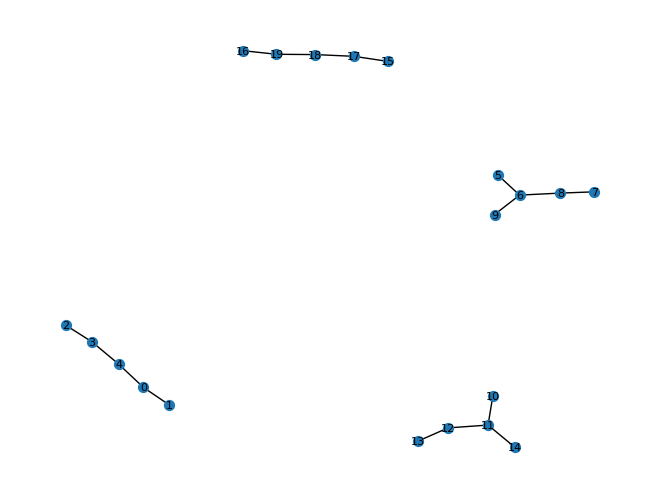

In [60]:
pos = nx.spring_layout(graph11)  # レイアウトの設定
nx.draw(graph11, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

In [84]:
AAAAA= similarity_graph.copy()

In [85]:
for i in graph11.edges:
    AAAAA.remove_edge(*i)

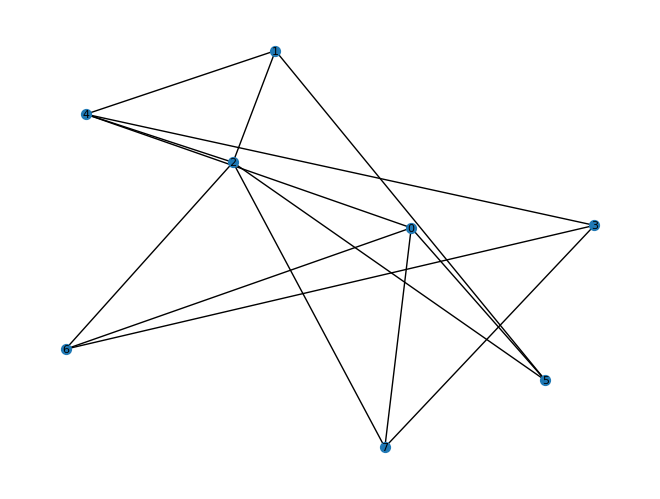

In [86]:
pos = nx.spring_layout(AAAAA)  # レイアウトの設定
nx.draw(AAAAA, pos, with_labels=True, node_size=50, font_size=8)
plt.show()